In [76]:
import requests
import json
import pandas as pd
import os
from pathlib import Path
import panel as pn
from panel.interact import interact
import plotly.express as px
import hvplot.pandas

import plotly.graph_objects as go  
from plotly.subplots import make_subplots

pn.extension("plotly")

In [24]:
# key initiation
api_key = os.getenv("ATTOM_API_KEY")
type(api_key)

str

In [25]:
def get_data_from_attom(url,querystring):    
    headers = { 
        'accept': "application/json", 
        'apikey': api_key, 
    } 

    response = requests.request("GET", url, headers=headers, params=querystring)
    print (response.url)
    json_formatted=json.loads(response.text)

    return json_formatted

In [26]:
# Reading junction files from the database later DB

neighborhood_match_csv = Path("data/zipcodeMapping.csv")
neighborhood_junction_file = pd.read_csv(neighborhood_match_csv)
neighborhood_junction_file.head()

,Borough,Neighborhood,ZIP Codes
0,Brooklyn,Central Brooklyn,"11212, 11213, 11216, 11233, 11238"
1,Brooklyn,Southwest Brooklyn,"11209, 11214, 11228"
2,Brooklyn,Borough Park,"11204, 11218, 11219, 11230"
3,Brooklyn,Canarsie and Flatlands,"11234, 11236, 11239"
4,Brooklyn,Southern Brooklyn,"11223, 11224, 11229, 11235"


In [27]:
# break down all the zipcode and create a new datafram
# Data clean up to find all the zip codes.
# intialize an array with all the zip codes.
all_zipcodes =[]
def clean_up_and_collect_zip(neighborhood_junction_file,all_zipcodes):
    for index, row in neighborhood_junction_file.iterrows():
        result = isinstance(row["ZIP Codes"], list)
        if (not result):
            zip_code_boroughs = [x.strip() for x in (row["ZIP Codes"]).split(',')]
            all_zipcodes.append(["ZI" + x for x in zip_code_boroughs])
            row["ZIP Codes"] = zip_code_boroughs
        else:
            all_zipcodes = all_zipcodes + ["ZI" + x for x in row["ZIP Codes"]]
    #         dict_neighborhood[row["Neighborhood"]] = [row["Borough"],zipcodelist
    return all_zipcodes
all_zipcodes = clean_up_and_collect_zip(neighborhood_junction_file,all_zipcodes)
neighborhood_junction_file.head()

,Borough,Neighborhood,ZIP Codes
0,Brooklyn,Central Brooklyn,"[11212, 11213, 11216, 11233, 11238]"
1,Brooklyn,Southwest Brooklyn,"[11209, 11214, 11228]"
2,Brooklyn,Borough Park,"[11204, 11218, 11219, 11230]"
3,Brooklyn,Canarsie and Flatlands,"[11234, 11236, 11239]"
4,Brooklyn,Southern Brooklyn,"[11223, 11224, 11229, 11235]"


In [28]:
# Read Rent Data from Zillow csv file
rent_data_csv = Path("data/Zip_Rent_2015.csv")
rent_data_csv = pd.read_csv(rent_data_csv)
rent_data_csv.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2015-01,2015-02,2015-03,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3682.0,3767.0,3767.0,...,3785.0,3788.0,3786.0,3784.0,3766.0,3779.0,3843.0,3873.0,3835.0,NaN
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,2016.0,2028.0,2033.0,...,2039.0,2070.0,2105.0,2140.0,2168.0,2185.0,2125.0,NaN,2053.0,1996.0
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,NaN,4011.0,3985.0,...,3874.0,3898.0,3917.0,3929.0,3931.0,3963.0,NaN,4123.0,4079.0,NaN
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,1945.0,1917.0,1906.0,...,1765.0,1755.0,1751.0,1752.0,1754.0,1759.0,1764.0,1769.0,1776.0,1778.0
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,2227.0,2232.0,2233.0,...,2245.0,2289.0,2332.0,2372.0,2398.0,2412.0,2348.0,2356.0,2311.0,NaN


In [29]:
cleaned_rent_data = rent_data_csv[rent_data_csv['City']=="New York"].drop(['2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07','2015-08','2015-09','2015-10','2015-11','2015-12',
                   '2016-01','2016-02','2016-03','2016-04','2016-05','2016-06','2016-07','2016-08','2016-09','2016-10','2016-11','2016-12',
                   '2017-01','2017-02','2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12',
                   '2018-01','2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2020-01',
                    'SizeRank','RegionID','Metro','State','City','CountyName']
                   ,axis=1)


cleaned_rent_data.dropna(inplace=True)
cleaned_rent_data.head()

,RegionName,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
14,10016,3241.0,3263.0,3251.0,3242.0,3245.0,3256.0,3286.0,3315.0,3340.0,3403.0,3440.0,3390.0
17,11201,2779.0,2813.0,2827.0,2829.0,2835.0,2846.0,2872.0,2892.0,2911.0,2914.0,2978.0,3038.0
18,11235,2087.0,2079.0,2070.0,2068.0,2070.0,2079.0,2092.0,2097.0,2097.0,2147.0,2147.0,2085.0
19,11375,2086.0,2092.0,2083.0,2070.0,2060.0,2058.0,2059.0,2058.0,2058.0,2114.0,2142.0,2105.0
23,10029,3145.0,3197.0,3225.0,3258.0,3276.0,3268.0,3242.0,3225.0,3199.0,3198.0,3144.0,3184.0


In [30]:
# get the 2019 snapshot of average rent
col = cleaned_rent_data.loc[: , "2019-01":"2019-12"]
cleaned_rent_data.insert(2, "Average Rent 2019", col.mean(axis=1), True) 
cleaned_rent_data.drop(['2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12'
                                       ],axis=1,inplace=True)
cleaned_rent_data.head()

,RegionName,Average Rent 2019
14,10016,3306.000000
17,11201,2877.833333
18,11235,2093.166667
19,11375,2082.083333
23,10029,3213.416667


In [31]:
cleaned_rent_data.rename(columns={'RegionName':'Zip Code'}, inplace=True)
cleaned_rent_data.set_index("Zip Code", inplace=True)

cleaned_rent_data.head()

,Average Rent 2019
Zip Code,
10016,3306.000000
11201,2877.833333
11235,2093.166667
11375,2082.083333
10029,3213.416667


In [32]:
# GET all the sales data

colnames = ["sno","Zip Code", "Date", "Num of Units Sold", "Average Sales", "Median Sales"]

# check to see if the file exists if so don't make API calls (because its a trial key we have limited usage)
def need_to_fetch_data():
    df=pd.DataFrame()
    path = Path('data/NYC_data.csv')
    if (path.exists()):
        print("File already exists no need to make expensive API calls")
        df = pd.read_csv(path, names=colnames, header=None)
    else: 
        print("BEGINNING THE API CALLS TO IMPORT DATA")
        
    return df


In [33]:
import time
sales_df = need_to_fetch_data()

# API REQUEST RESTRICTION: cannot make more than 7-9 requests a minute! Also they don't have bulk zipcode calls
# So put a sleep timer to collect the data

if(sales_df.empty):    
    url = "https://api.gateway.attomdata.com/propertyapi/v1.0.0/salestrend/snapshot"
    all_data_df = pd.DataFrame()
    for zipcode_list in all_zipcodes[41:42]:
        for zipcode in zipcode_list:
            print(zipcode)
            sale = []
            querystring = {"geoid":zipcode,"interval":"monthly","startyear":"2010","endyear":"2019","startmonth":"january","endmonth":"december"}
            print (querystring)
            json_formatted = get_data_from_attom(url,querystring)
            for row in json_formatted['salestrends']:
                location = row['location']['geoID']
                date = row['daterange']['start']
                homesalecount = row['SalesTrend']['homesalecount']
                avgsaleprice = row['SalesTrend']['avgsaleprice']
                medsaleprice = row['SalesTrend']['medsaleprice']     
                sale.append([location,date, homesalecount, avgsaleprice,medsaleprice])
            df = pd.DataFrame(columns=['location', 'date','homesalecount','avgsaleprice','medsaleprice'], data=sale)
            df['date']= pd.to_datetime(df['date']) 
            all_data_df.append(df)
            # df.set_index('date', inplace=True)
            filename = 'data/NYC_data.csv'
            # put it all in the csv file 
            df.to_csv(filename, mode='a', header=False)      
        time.sleep(40)


sales_df['Date']= pd.to_datetime(sales_df['Date'])
sales_df.tail()

File already exists no need to make expensive API calls


,sno,Zip Code,Date,Num of Units Sold,Average Sales,Median Sales
10370,10370,ZI11378,2019-08-01,17,773059,800000
10371,10371,ZI11378,2019-09-01,9,796543,728000
10372,10372,ZI11378,2019-10-01,23,813887,770000
10373,10373,ZI11378,2019-11-01,19,790448,820000
10374,10374,ZI11378,2019-12-01,13,876808,885000


In [34]:
# Clean up date

#zip code format
sales_df['Zip Code'] = (sales_df['Zip Code']).str[2:]
sales_df.dropna(inplace=True)
sales_df
sales_df.drop(columns=['sno'], inplace=True)
sales_df.head()

,Zip Code,Date,Num of Units Sold,Average Sales,Median Sales
0,11212,2015-01-01,12,1551110,479375
1,11212,2015-02-01,13,1148923,450000
2,11212,2015-03-01,27,3250758,419967
3,11212,2015-05-01,13,332615,330000
4,11212,2015-06-01,16,787406,540000


In [151]:

list_of_boroughs = []
list_of_neighborhoods = []

# take the row get the zipcode
for x, row in sales_df.iterrows():
    zipcode = row[0].strip()
    region = [row for x, row in neighborhood_junction_file.iterrows() if zipcode in row['ZIP Codes']]
    if len(region) > 0:
         list_of_boroughs.append(region[0]['Borough'])
         list_of_neighborhoods.append(region[0]['Neighborhood'])

borough = pd.Series(list_of_boroughs)  
sales_df.insert(loc=0, column='Borough', value=borough)


neighborhood = pd.Series(list_of_neighborhoods)  
sales_df.insert(loc=1, column='Neighborhood', value=neighborhood)
sales_df.head()


ValueError: cannot insert Borough, already exists

In [36]:
sales_df.set_index('Date',inplace =True)



,Borough,Neighborhood,Zip Code,Num of Units Sold,Average Sales,Median Sales
Date,,,,,,
2019-08-01,Queens,West Queens,11378,17,773059,800000
2019-09-01,Queens,West Queens,11378,9,796543,728000
2019-10-01,Queens,West Queens,11378,23,813887,770000
2019-11-01,Queens,West Queens,11378,19,790448,820000
2019-12-01,Queens,West Queens,11378,13,876808,885000


In [37]:
from urllib.request import urlopen
import json

with open('data/nyc_zip_code_tabulation_areas_polygons.geojson') as f:
    counties = json.load(f)
df = sales_df

In [38]:
df.sort_index(inplace=True)
df = sales_df[df.index.year == 2019].groupby(['Zip Code']).mean()
df.head()

,Num of Units Sold,Average Sales,Median Sales
Zip Code,,,
10001,7.916667,2.035934e+06,1.645208e+06
10002,12.666667,1.409571e+06,9.454452e+05
10003,33.666667,1.873652e+06,1.139133e+06
10004,3.300000,1.198057e+06,9.016206e+05
10005,6.750000,1.366823e+06,1.251829e+06


In [69]:
# fig = px.choropleth_mapbox(df, geojson=counties, locations=df.index, color='Average Sales',
#                            color_continuous_scale="inferno",featureidkey="properties.postalcode",
#                            range_color=(0, 4600000),
#                            mapbox_style="carto-positron", 
#                            zoom=9.9, center = {"lat": 40.7048, "lon": -73.9419},
#                            opacity=0.5,
#                            width = 800
#                            ,title="Average Sales in 2019 by Zip Code"
#                            ,labels={'Average Sales 2019':'Average Sales 2019'}
#                           )
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()
    

In [70]:
# merge the rent file

df.head()
df.sort_index(inplace=True)


In [71]:
df.index = df.index.astype('int64')
df.head()

,Num of Units Sold,Average Sales,Median Sales
Zip Code,,,
10001,7.916667,2.035934e+06,1.645208e+06
10002,12.666667,1.409571e+06,9.454452e+05
10003,33.666667,1.873652e+06,1.139133e+06
10004,3.300000,1.198057e+06,9.016206e+05
10005,6.750000,1.366823e+06,1.251829e+06


In [158]:
# merge rent data, average sales and return

cleaned_rent_data.sort_index(inplace=True)
df_new = pd.concat([df,cleaned_rent_data], axis=1, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

df_new.fillna(0, inplace=True)
df_new['ROI'] = df_new['Average Rent 2019']/df_new['Average Sales'] * 100
df_new.head()

,Num of Units Sold,Average Sales,Median Sales,Average Rent 2019,ROI
Zip Code,,,,,
10001,7.916667,2.035934e+06,1.645208e+06,3639.250000,0.178751
10002,12.666667,1.409571e+06,9.454452e+05,0.000000,0.000000
10003,33.666667,1.873652e+06,1.139133e+06,0.000000,0.000000
10004,3.300000,1.198057e+06,9.016206e+05,3960.333333,0.330563
10005,6.750000,1.366823e+06,1.251829e+06,3961.500000,0.289833


In [159]:
fig = px.choropleth_mapbox(df_new, geojson=counties, locations=df_new.index, color='Average Sales',
                           color_continuous_scale="inferno",featureidkey="properties.postalcode",
                           range_color=(100000, 4000000),
                           mapbox_style="carto-positron", 
                           zoom=10, center = {"lat": 40.7048, "lon": -73.9419},
                           opacity=0.5,
                           width = 800
                           ,hover_name = df_new.index
                           ,hover_data=df_new[["Average Sales", "Average Rent 2019", "ROI"]]
                           ,title="Average Sales in 2019 by Zip Code"
                           ,labels={'Average Sales 2019':'Average Sales 2019'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
    

In [74]:
sales_grouped_date = sales_df.groupby(sales_df.index.year).mean()
sales_grouped_date

,Num of Units Sold,Average Sales,Median Sales
Date,,,
2015,24.049133,9.915098e+05,660365.120906
2016,23.056731,1.031253e+06,737353.441827
2017,22.725962,1.035852e+06,765641.041827
2018,18.692940,1.090809e+06,836714.370406
2019,16.743119,1.009635e+06,795491.393530


In [150]:
by_borough_2019 = sales_df[sales_df.index.year == 2019].groupby(['Neighborhood']).mean()
by_borough_2019.hvplot.bar(x='Neighborhood',y='Average Sales',rot=90).opts(height=500, width=900, title="Average Sales of 2019 by Neighborhood")


:Bars   [Neighborhood]   (Average Sales)

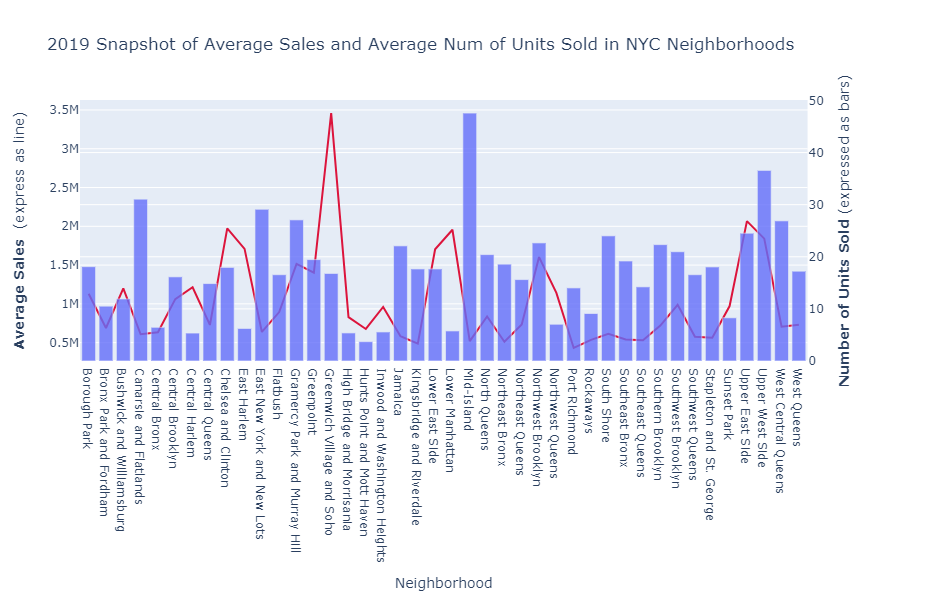

In [148]:
fig1 = px.line(by_borough_2019, x=by_borough.index, y=by_borough["Average Sales"])
fig1.update_traces(line_color='#DC143C')

fig2 = px.bar(by_borough_2019, x=by_borough.index, y=by_borough["Num of Units Sold"],opacity=0.8)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    fig1.data[0],
    secondary_y=False,
)

fig.add_trace(
    fig2.data[0],
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="2019 Snapshot of Average Sales and Average Num of Units Sold in NYC Neighborhoods"
    , height=600
)

# Set x-axis title
fig.update_xaxes(title_text="Neighborhood")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Average Sales </b> (express as line)", secondary_y=False)
fig.update_yaxes(title_text="<b>Number of Units Sold</b> (expressed as bars)", secondary_y=True)

fig.show()

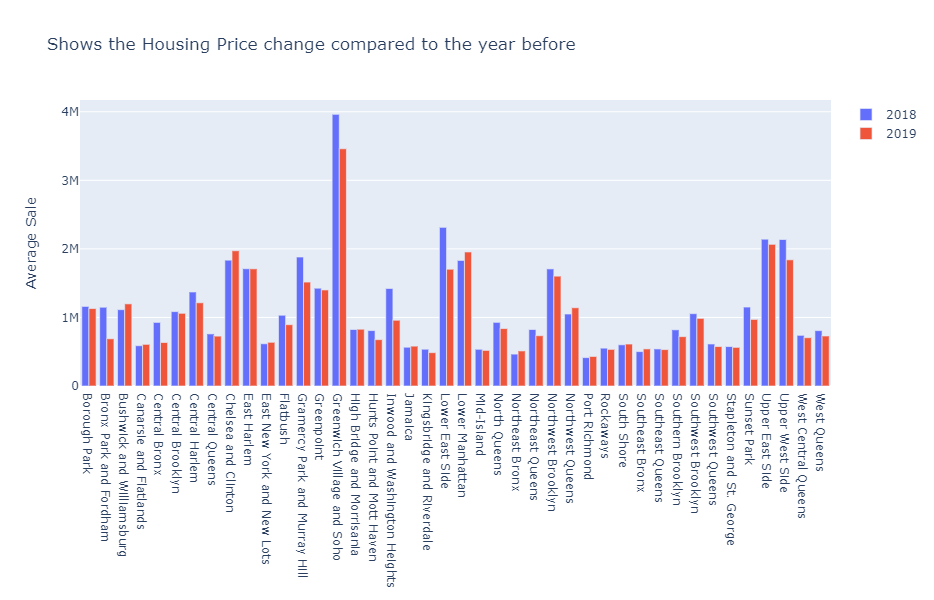

In [143]:
# compares two YoY changes for Average Sales 

by_borough_2018 = sales_df[sales_df.index.year == 2018].groupby(['Neighborhood']).mean()

fig = go.Figure(
    data=
    [
    go.Bar(name='2018', x=by_borough_2019.index, y=by_borough_2018['Average Sales']),
    go.Bar(name='2019', x=by_borough_2019.index, y=by_borough_2019['Average Sales'])    
],
    layout=go.Layout(
        title="Shows the Housing Price change compared to the year before",
        yaxis_title="Average Sale"
        ,height=600
    )
)

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()